<a href="https://colab.research.google.com/github/AlphaZero28/supercontinuum-generation-pynlo/blob/main/fiber1_SCG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pynlo
!pip install scipy==1.2 --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 KB 322.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 1.7 MB/s eta 0:00:00
  Created wheel for pynlo: filename=pyNLO-0.1.2-py3-none-any.whl size=77537 sha256=c75306c46d0c5fb03bfd90ec77591975d71f1b0a89a1daedd2e9c72f92cc162a
  Stored in directory: /root/.cache/pip/wheels/7e/f0/e1/11ae6b543a4099dd12bd2e3013b05131ab566af9df8386cda3
Successfully built pynlo
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and

In [ ]:
 # basic imports and google drive setup
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
#from google.colab import files, drive
#drive.mount('/content/drive')
#scg_drive = '/content/drive/MyDrive/data/scg'

def getTimeAsFileName():
  now = datetime.now()+timedelta(hours=6)
  return(now.strftime("%y.%m.%d.%I.%M%p"))

def normalize_log_data(zW):
  z_new = []
  for i in range(len(zW)):
    d = 10*np.log10((10**(zW[i]/10))/max(10**(zW[i]/10)))
    z_new.append(d)
  return z_new

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
#setup
import pynlo

P0 = 0.5 # power (kw)
FWHM    = 0.05  # pulse duration (ps)
pulseWL = 1200   # pulse central wavelength (nm)
EPP     = (P0*1e3)*(FWHM*1e-12)/0.88 # (2*10**3)*(50*10**-15)/0.88 # Energy per pulse (J)

Length  = 5    # length in mm
Gamma   = 22.01e3   # Gamma (1/(W km))
fibWL   = pulseWL # Center WL of fiber (nm)

Window  = 80.0   # simulation window (ps)
Steps   = 150     # simulation steps
Points  = 2**16 #420THz #(2**17/1.3)  # simulation points

beta2 = -4.3372e+01
beta3 = 2.9063e-01
beta4 = -5.0112e-04
beta5 = 1.4268e-06
beta6 = -4.5986e-09
beta7 = 1.6898e-11
beta8 = 1.9995e-14
beta9 = -6.3870e-15
beta10 = -2.0522e-15

betas = (beta2, beta3, beta4, beta5,beta6) #, beta6, beta7, beta8, beta9, beta10)
Raman   = False    # Enable Raman effect?

GDD     = 0.0    # Group delay dispersion (ps^2)
TOD     = 0.0    # Third order dispersion (ps^3)

Alpha   = 0.0     # attentuation coefficient (dB/cm)

Steep   = False    # Enable self steepening?

alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

In [ ]:
######## This is where the PyNLO magic happens! ############################

# create the pulse!
pulse = pynlo.light.DerivedPulses.SechPulse(1, FWHM/1.76, pulseWL, time_window_ps=Window,
                  GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=100, power_is_avg=False)
pulse.set_epp(EPP) # set the pulse energy

# create the fiber!
fiber1 = pynlo.media.fibers.fiber.FiberInstance()
fiber1.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=betas,
                              gamma_W_m=Gamma * 1e-3, gvd_units='ps^n/km', gain=-alpha)

# Propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.005, USE_SIMPLE_RAMAN=True,
                 disable_Raman=np.logical_not(Raman),f_R = 0.1, f_R0 = 0.1, tau_1 = 0.0231, tau_2 = 0.195,
                 disable_self_steepening=np.logical_not(Steep))

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps)

########## That's it! Physic done. Just boring plots from here! ################


F = pulse.W_mks / (2 * np.pi) * 1e-12 # convert to THz

def dB(num):
    return 10 * np.log10(np.abs(num)**2)

zW = dB( np.transpose(AW)[:, (F > 0)] )
zT = dB( np.transpose(AT) )

y = y * 1e3 # convert distance to mm

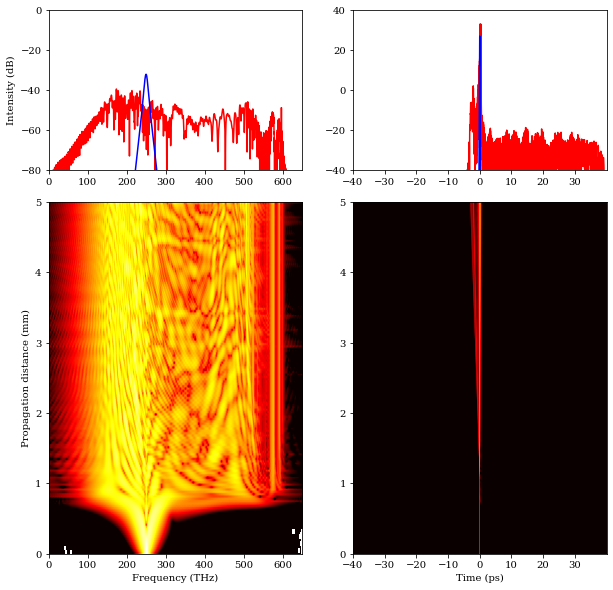

In [ ]:
# set up plots for the results:
fig = plt.figure(figsize=(10,10))
ax0 = plt.subplot2grid((3,2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3,2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3,2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3,2), (1, 1), rowspan=2, sharex=ax1)

ax0.plot(F[F > 0],  zW[-1], color='r')
ax1.plot(pulse.T_ps,zT[-1], color='r')

ax0.plot(F[F > 0],   zW[0], color='b')
ax1.plot(pulse.T_ps, zT[0], color='b')


extent = (np.min(F[F > 0]), np.max(F[F > 0]), 0, Length)
ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 60.0,
                 vmax=np.max(zW), aspect='auto', origin='lower',cmap='hot')

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y), Length)
ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
           vmax=np.max(zT), aspect='auto', origin='lower',cmap='hot')


ax0.set_ylabel('Intensity (dB)')

ax2.set_xlabel('Frequency (THz)')
ax3.set_xlabel('Time (ps)')

ax2.set_ylabel('Propagation distance (mm)')

ax2.set_xlim(0,650)

ax0.set_ylim(-80,0)
ax1.set_ylim(-40,40)

plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


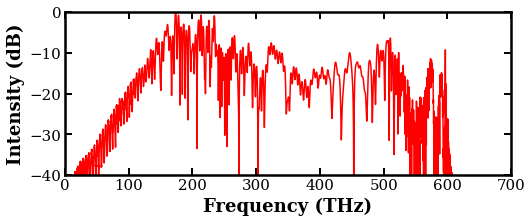

In [ ]:
zWn = normalize_log_data(zW)
plt.figure(figsize=(8,3))
plt.plot(F[F>0], zWn[-1], color='r')
plt.xlim(0,700)
plt.ylim(-40,0)
plt.ylabel('Intensity (dB)',fontsize=18,fontweight='bold')
plt.xlabel('Frequency (THz)',fontsize=18,fontweight='bold')
plt.xticks(np.arange(0,800,100))
#plt.yticks(np.arange(-80,0,20))

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.tick_params(labelsize=15,direction='in',length=7,width=2,bottom=True,top=True,left=True,right=True)

In [ ]:
def conv2wavelength(freq):
  c = 3e8
  lam = c/freq*1e6;
  print(lam)



In [ ]:
conv2wavelength(20e12)

15.0


In [ ]:
conv2wavelength(610e12)

0.49180327868852464
